# Introduction

### This project report will include
1. Explanation of the purpose, and background on my project
2. A in-depth explanation of my data merging


## Purpose
The purpose of this project report (in notebook form) is to show some exploratory data analysis and data cleaning for this particular project. This project set out to reveal information about the relationship between population demographic information and the uptake in solar power. In particular, the purpose was to determine whether race or income was more significant in solar power uptake. 

## Background
The initial inspiration for this project was a Graduate Mechanical Engineering seminar at Tufts University. The talk, given on Thursday February 7th, 2019, was titled titled “Energy Injustice: Disparities in Rooftop Photovoltaics Deployment in the United States.” The abstract of the talk was as follows: 

“The rooftop solar industry in the United States has experienced dramatic growth—roughly 50% per year since 2012, along with steadily falling prices. Although the opportunities this affords for clean, reliable power are transformative, the benefits might not accrue to all individuals and communities. Combining the location of existing and potential sites for rooftop photovoltaics (PV) from Google’s Project Sunroof and demographic information from the American Community Survey, the relative adoption of rooftop PV is compared across census tracts based on median household income, home ownership, and race and ethnicity. The historical context of energy injustice in this country will be discussed, as well as the importance for engineers today to holistically consider sustainability: environmentally, economically, and socially.”

During the talk, Professor Sunter detailed how she ran regressions on data sets from the American Community Survey (ACS) and Google’s Project Sunroof program to determine the factor that most significantly affects solar power uptake. Since the ACS, which is administered by the US Census Bureau, ties geography to certain population characteristics (e.g. race, income, and age), and the Project Sunroof data set details solar power characteristics (e.g. number of solar panels), she was able statistically detail the effect of race on solar deployment. Since both data sets provided information at the census tract level, that was chosen as the geographic level of interest.  

As a first foray into data science techniques, I will try to replicate the work that Professor Sunter has done. In her paper, “Disparities in rooftop photovoltaics deployment in the United States by race and ethnicity”, Professor Sunter details her methods for determining if there are significant differences between races in solar deployment, all else equal. One significant reason for replication of this study is that the ACS data set that was utilized in the study came from the 2009-2013 5-year ACS. In my project, I will be using the 2012-2017 5-year ACS data set, providing a much more recent set of population characteristics. 

Solar power companies have approached Professor Sunter about the results of her data analysis to determine ways to equalize, from a racial point of view, access and usage of solar power. Solar power has the potential to pay for itself, reducing or eliminating the electricity bill of its users, with the caveat of significant policy differences between states. 


## Initialization
Below are some of the tools that I used to conduct the data exploration and  visuaization. 

In [20]:
import pandas as pd
import seaborn as sns
import geopandas as gpd
import numpy as np
from census import Census
from us import states
import time
import os
import re
import pathlib
import urllib
import zipfile
import io
import requests
import matplotlib.pyplot as plt
import pysal as ps
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import l1_min_c
from sklearn.metrics import roc_curve, auc

## Acquiring Datasets
There are two data sets that are read into the analysis. The first is the American Community Survey (ACS), part of the US Census's collected data. The particular ACS data that is read in is the 5-year aggregate collected in the years 2013-2017. Using the "census" wrapper (as was suggested by the official Census website), the cell below scrapes the data set, collecting information on total population of all counties. 

I then decided that I would focus mainly on the most populous counties in the US, as a proxy for the popularity of solar panels. This idea was inspired by Google Project Sunroof's machine learning algorithm. The team fed the algorithm mainly aerial imagery from areas that were more dense in their solar panel coverage in order to expose the algorithm to more positive hits. In the code, I sorted all the counties in the US by total county population and then chose a number of those most populous counties to continue on with.

Using the Census wrapper, a dataframe called censusdata was built, collecting data on total population, racial demographic information, and income on each of the census tracts in each of those very populous counties. Some data cleaning occurs in the block of code, there are some census tracts with very low populations that were excluded and there were also some negative income values for some census tracts. These census tracts were dropped from the analysis. 

In [2]:
start = time.time()
c = Census("03b8bb083da55549598393f0f23156a48c2c0c85", year=2017)
county = c.acs5.get(('NAME', 'B01003_001E'), {'for':'county:*'})
df = pd.DataFrame(county)
countysort = df.sort_values(["B01003_001E"], axis = 0, ascending = False)
countysortshort = countysort.head(5)
css = countysortshort

#df2 = pd.DataFrame(c.acs5.state_county_tract(('NAME', 'B01003_001E','B02001_002E', 'B02001_003E', 'B02001_005E', 'B03002_012E', 'B19013_001E'), css.iloc[0,3], css.iloc[0,2], Census.ALL))
countyData = pd.DataFrame(c.acs5.state_county_tract(('NAME', 'B01003_001E','B02001_002E', 'B02001_003E', 'B02001_005E', 'B03002_012E', 'B19013_001E'), css.iloc[0,3], css.iloc[0,2], Census.ALL))
for x in range(1,len(css)):
    df = pd.DataFrame(c.acs5.state_county_tract(('NAME', 'B01003_001E','B02001_002E', 'B02001_003E', 'B02001_005E', 'B03002_012E', 'B19013_001E'), css.iloc[x,3], css.iloc[x,2], Census.ALL))
    countyData = countyData.append(df, ignore_index = True)
    #print("I am at step ", x)
print('Out of Loop')

countyData['tractID'] = countyData['state'].str.cat(countyData['county'],sep="").str.cat(countyData['tract'], sep="")
censusdata = countyData
censusdata.tractID = censusdata.tractID.astype(float)
censusdata.columns = ['TotalPopulation', 'White', 'Black', 'Asian', 'Hispanic','Income', 'NAME', 'county', 'state', 'tract', 'GEOID']
censusdata = censusdata.drop(['state', 'tract'], axis = 1)
censusdatasort = censusdata.sort_values(["GEOID"], axis = 0, ascending = True)
#censusdatasort
censusData = censusdatasort.drop(censusdatasort[censusdatasort.TotalPopulation<1500].index)
censusData = censusData.drop(censusData[censusData.Income<0].index)
end = time.time()
total = end-start
print('Operation took', total, 'seconds')
censusData.head()

Out of Loop
Operation took 11.452179431915283 seconds


,TotalPopulation,White,Black,Asian,Hispanic,Income,NAME,county,GEOID
4880,4915.0,4814.0,0.0,19.0,78.0,87167.0,"Census Tract 101.01, Maricopa County, Arizona",013,4.013010e+09
4902,4602.0,4408.0,25.0,134.0,59.0,115725.0,"Census Tract 101.02, Maricopa County, Arizona",013,4.013010e+09
4985,4539.0,4472.0,0.0,62.0,170.0,113889.0,"Census Tract 304.01, Maricopa County, Arizona",013,4.013030e+09
4905,4243.0,4031.0,17.0,0.0,121.0,81994.0,"Census Tract 304.02, Maricopa County, Arizona",013,4.013030e+09
4468,5110.0,4762.0,0.0,4.0,834.0,40434.0,"Census Tract 405.02, Maricopa County, Arizona",013,4.013041e+09


## More Data Import: Google Project Sunroof
The next few lines simply put the data from Google Project sunroof into its own dataframe. Additionally, the column that the Sunroof data had called region_name, which stored its own census tract number information, was converted to floats (rather than object data types) and renamed tractID. This is to facilitate the merging of the two datasets using the 'merge' command in pandas. 



In [3]:
start = time.time()
sunroofData = pd.DataFrame(pd.read_csv('https://storage.googleapis.com/project-sunroof/csv/latest/project-sunroof-census_tract.csv'))
sunroofData.region_name = sunroofData.region_name.astype(float)
sunroofData.rename(columns={'region_name':'GEOID'}, inplace=True)
end = time.time()
duration = end-start
print('Operation took', duration, 'seconds')
sunroofData.head()

Operation took 22.16959834098816 seconds


,GEOID,state_name,lat_max,lat_min,lng_max,lng_min,lat_avg,lng_avg,yearly_sunlight_kwh_kw_threshold_avg,count_qualified,...,yearly_sunlight_kwh_n,yearly_sunlight_kwh_s,yearly_sunlight_kwh_e,yearly_sunlight_kwh_w,yearly_sunlight_kwh_f,yearly_sunlight_kwh_median,yearly_sunlight_kwh_total,install_size_kw_buckets_json,carbon_offset_metric_tons,existing_installs_count
0,1.001020e+09,Alabama,32.505161,32.449730,-86.475128,-86.510422,32.477184,-86.490082,1095.65,591.0,...,6.735739e+05,3.744787e+06,2.558342e+06,2.776739e+06,2.567009e+06,14854.402856,1.232045e+07,"[[0,76],[5,163],[10,136],[15,78],[20,52],[25,2...",7325.568357,0.0
1,1.001020e+09,Alabama,32.489342,32.456120,-86.465378,-86.481270,32.474255,-86.473381,1095.65,718.0,...,1.354248e+06,4.702247e+06,2.993705e+06,2.978384e+06,6.819697e+06,13564.145190,1.884828e+07,"[[0,122],[5,200],[10,168],[15,89],[20,46],[25,...",11206.925804,0.0
2,1.001020e+09,Alabama,32.491909,32.459209,-86.450684,-86.470871,32.475426,-86.460190,1095.65,1121.0,...,2.010001e+06,7.390340e+06,3.998881e+06,4.096211e+06,8.226100e+06,12725.930640,2.572153e+07,"[[0,167],[5,363],[10,258],[15,150],[20,61],[25...",15293.664803,1.0
3,1.001020e+09,Alabama,32.493690,32.447208,-86.432381,-86.453941,32.472000,-86.443619,1095.65,1491.0,...,2.840030e+06,1.006799e+07,5.554514e+06,6.354775e+06,4.816764e+06,16586.321436,2.963407e+07,"[[0,174],[5,332],[10,350],[15,285],[20,185],[2...",17620.007964,0.0
4,1.001020e+09,Alabama,32.485748,32.424000,-86.411346,-86.438423,32.458832,-86.422661,1095.65,3378.0,...,4.317376e+06,2.930909e+07,1.692559e+07,1.866793e+07,2.059855e+07,17536.774170,8.981854e+07,"[[0,151],[5,737],[10,1047],[15,758],[20,345],[...",53404.855511,8.0


Originally, merging was attempted using an if statement nested within a for loop which was nested in another for loop. Then the sunroofData and the censusData dataframes were merged using the 'merge' command. This massively improved the time that it took to combine the two dataframes. 

In [4]:
start = time.time()
combined = pd.merge(sunroofData,censusData)
end = time.time()
total = end-start
print('Operation took', total, ' seconds.')
combined.head()

Operation took 0.06973743438720703  seconds.


,GEOID,state_name,lat_max,lat_min,lng_max,lng_min,lat_avg,lng_avg,yearly_sunlight_kwh_kw_threshold_avg,count_qualified,...,carbon_offset_metric_tons,existing_installs_count,TotalPopulation,White,Black,Asian,Hispanic,Income,NAME,county
0,4.013010e+09,Arizona,34.037331,33.464901,-111.039902,-112.065399,33.743378,-111.546242,1365.1,2944.0,...,52048.893549,134.0,4602.0,4408.0,25.0,134.0,59.0,115725.0,"Census Tract 101.02, Maricopa County, Arizona",013
1,4.013030e+09,Arizona,33.853031,33.791840,-111.891182,-111.964851,33.816788,-111.916748,1365.1,2917.0,...,47782.648106,105.0,4539.0,4472.0,0.0,62.0,170.0,113889.0,"Census Tract 304.01, Maricopa County, Arizona",013
2,4.013030e+09,Arizona,33.900558,33.799080,-111.891251,-111.995979,33.860039,-111.936821,NaN,0.0,...,0.000000,0.0,4243.0,4031.0,17.0,0.0,121.0,81994.0,"Census Tract 304.02, Maricopa County, Arizona",013
3,4.013030e+09,Arizona,33.900558,33.799080,-111.891251,-111.995979,33.860039,-111.936821,1365.1,2574.0,...,32251.907799,120.0,4243.0,4031.0,17.0,0.0,121.0,81994.0,"Census Tract 304.02, Maricopa County, Arizona",013
4,4.013041e+09,Arizona,33.672272,33.638569,-112.324783,-112.358727,33.657543,-112.338348,1365.1,3261.0,...,51711.565712,0.0,5404.0,5306.0,27.0,0.0,17.0,40978.0,"Census Tract 405.06, Maricopa County, Arizona",013


To simplify the dataframe, the following cell eliminates the variables that are not relevant; this just makes it easier to view the relevant data. 

In [5]:
combined = combined.drop(columns = ['lat_max', 'lat_min', 'lng_max', 'lng_min', 'lat_avg', 'lng_avg', 'yearly_sunlight_kwh_kw_threshold_avg', 'count_qualified', 'percent_covered', 'percent_qualified', 'number_of_panels_n', 'number_of_panels_s', 'number_of_panels_e', 'number_of_panels_w', 'number_of_panels_f', 'number_of_panels_median', 'kw_median', 'kw_total', 'yearly_sunlight_kwh_n', 'yearly_sunlight_kwh_s', 'yearly_sunlight_kwh_e', 'yearly_sunlight_kwh_w', 'yearly_sunlight_kwh_f', 'yearly_sunlight_kwh_median', 'yearly_sunlight_kwh_total', 'install_size_kw_buckets_json', 'carbon_offset_metric_tons', 'existing_installs_count', 'NAME'])


In [6]:
combined

,GEOID,state_name,number_of_panels_total,TotalPopulation,White,Black,Asian,Hispanic,Income,county
0,4.013010e+09,Arizona,301364.0,4602.0,4408.0,25.0,134.0,59.0,115725.0,013
1,4.013030e+09,Arizona,276815.0,4539.0,4472.0,0.0,62.0,170.0,113889.0,013
2,4.013030e+09,Arizona,NaN,4243.0,4031.0,17.0,0.0,121.0,81994.0,013
3,4.013030e+09,Arizona,186557.0,4243.0,4031.0,17.0,0.0,121.0,81994.0,013
4,4.013041e+09,Arizona,298081.0,5404.0,5306.0,27.0,0.0,17.0,40978.0,013
5,4.013041e+09,Arizona,340237.0,6395.0,6213.0,69.0,63.0,29.0,42378.0,013
6,4.013041e+09,Arizona,79921.0,1747.0,1676.0,16.0,14.0,18.0,47271.0,013
7,4.013041e+09,Arizona,162335.0,2971.0,2925.0,9.0,0.0,9.0,54132.0,013
8,4.013041e+09,Arizona,163434.0,3074.0,2986.0,9.0,69.0,64.0,47424.0,013
9,4.013041e+09,Arizona,38653.0,7597.0,6668.0,447.0,102.0,1064.0,58276.0,013


## Next Steps

My next steps will include using Geopandas to visualize the demographic data in a select few counties, likely the largest counties, by census tract, as well as more exploratory data analysis.  

Then I will hopefully use some of the topics that we learned about more complex data science concepts like random forests to find out the most significant reason for uptake in solar power. 

The cell below downloads the shapefile for the all the census tracts in the state in interest. 

In [7]:
state_url = 'https://www2.census.gov/geo/tiger/TIGER2017/TRACT/tl_2017_04_tract.zip'
print('downloading shapefile')
r = requests.get(state_url)
print ('Done')


downloading shapefile
Done


In [8]:
z = zipfile.ZipFile(io.BytesIO(r.content), 'r')
print ('Done')

Done


In [9]:
z.extractall(path=None)

In [10]:
tracts = gpd.read_file("tl_2017_04_tract.shp")
print("Shape of the dataframe: {}".format(tracts.shape))
print("Projection of dataframe: {}".format(tracts.crs))
tracts.head() #last 5 records in dataframe

Shape of the dataframe: (1526, 13)
Projection of dataframe: {'init': 'epsg:4269'}


,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,019,003003,04019003003,30.03,Census Tract 30.03,G5020,S,2053859,0,+32.2471612,-110.8661956,"POLYGON ((-110.879843 32.249263, -110.879835 3..."
1,04,019,003707,04019003707,37.07,Census Tract 37.07,G5020,S,1522818,0,+32.1518293,-110.9522876,"POLYGON ((-110.96121 32.155971, -110.961056 32..."
2,04,019,004067,04019004067,40.67,Census Tract 40.67,G5020,S,1851359,0,+32.2405665,-110.8490480,"POLYGON ((-110.857923 32.235899, -110.857892 3..."
3,04,019,003303,04019003303,33.03,Census Tract 33.03,G5020,S,3004756,0,+32.2206105,-110.8666444,"POLYGON ((-110.875472 32.228808, -110.875463 3..."
4,04,019,003706,04019003706,37.06,Census Tract 37.06,G5020,S,1371036,0,+32.1596545,-110.9523197,"POLYGON ((-110.961243 32.163348, -110.961077 3..."


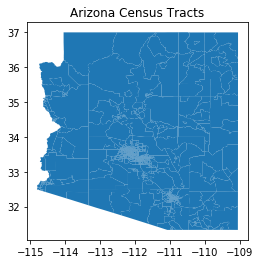

In [11]:
ax = tracts.plot()
ax.set_title("Arizona Census Tracts");

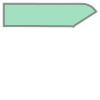

In [12]:
tracts.loc[0,'geometry']

In [13]:
tracts.COUNTYFP = tracts.COUNTYFP.astype(float)

tracts.loc[tracts['COUNTYFP'] == 13]

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
11,04,13.0,093104,04013093104,931.04,Census Tract 931.04,G5020,S,3949828,4649,+33.5158664,-112.1712744,"POLYGON ((-112.18636 33.509569, -112.186353 33..."
12,04,13.0,103205,04013103205,1032.05,Census Tract 1032.05,G5020,S,2635515,0,+33.6042712,-111.9694857,"POLYGON ((-111.980315 33.598882, -111.979689 3..."
13,04,13.0,103206,04013103206,1032.06,Census Tract 1032.06,G5020,S,2573798,0,+33.6042060,-111.9519100,"POLYGON ((-111.960605 33.597313, -111.960599 3..."
14,04,13.0,104501,04013104501,1045.01,Census Tract 1045.01,G5020,S,1227304,23667,+33.5709186,-112.0944957,"POLYGON ((-112.097922 33.574878, -112.09704 33..."
15,04,13.0,104502,04013104502,1045.02,Census Tract 1045.02,G5020,S,1342092,0,+33.5782693,-112.0905724,"POLYGON ((-112.099614 33.57568699999999, -112...."
16,04,13.0,105002,04013105002,1050.02,Census Tract 1050.02,G5020,S,8045189,2469,+33.5228894,-111.9475270,"POLYGON ((-111.975613 33.530534, -111.975606 3..."
17,04,13.0,107900,04013107900,1079,Census Tract 1079,G5020,S,7776244,4519,+33.5121470,-111.9639086,"POLYGON ((-111.995315 33.510613, -111.995314 3..."
18,04,13.0,108000,04013108000,1080,Census Tract 1080,G5020,S,3793384,16550,+33.4970552,-111.9596525,"POLYGON ((-111.977205 33.496361, -111.977117 3..."
19,04,13.0,116721,04013116721,1167.21,Census Tract 1167.21,G5020,S,2295744,0,+33.3092109,-112.0136469,"POLYGON ((-112.027454 33.308742, -112.027435 3..."
20,04,13.0,116725,04013116725,1167.25,Census Tract 1167.25,G5020,S,4158254,0,+33.2974010,-112.0469872,"POLYGON ((-112.063592 33.293331, -112.063578 3..."


In [14]:
tracts.GEOID = tracts.GEOID.astype(float)
combined2 = pd.merge(tracts,combined)
combined2.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,geometry,state_name,number_of_panels_total,TotalPopulation,White,Black,Asian,Hispanic,Income,county
0,04,13.0,093104,4.013093e+09,931.04,Census Tract 931.04,G5020,S,3949828,4649,...,"POLYGON ((-112.18636 33.509569, -112.186353 33...",Arizona,234845.0,4808.0,3789.0,434.0,48.0,3106.0,24068.0,013
1,04,13.0,103205,4.013103e+09,1032.05,Census Tract 1032.05,G5020,S,2635515,0,...,"POLYGON ((-111.980315 33.598882, -111.979689 3...",Arizona,97097.0,2928.0,2801.0,37.0,12.0,124.0,98088.0,013
2,04,13.0,103206,4.013103e+09,1032.06,Census Tract 1032.06,G5020,S,2573798,0,...,"POLYGON ((-111.960605 33.597313, -111.960599 3...",Arizona,95602.0,2587.0,2276.0,44.0,99.0,202.0,113889.0,013
3,04,13.0,104501,4.013105e+09,1045.01,Census Tract 1045.01,G5020,S,1227304,23667,...,"POLYGON ((-112.097922 33.574878, -112.09704 33...",Arizona,52727.0,3872.0,2671.0,239.0,48.0,2199.0,25404.0,013
4,04,13.0,104502,4.013105e+09,1045.02,Census Tract 1045.02,G5020,S,1342092,0,...,"POLYGON ((-112.099614 33.57568699999999, -112....",Arizona,60429.0,5691.0,4893.0,400.0,0.0,3675.0,26986.0,013


Text(0.5, 1.0, '# of Solar Panels')

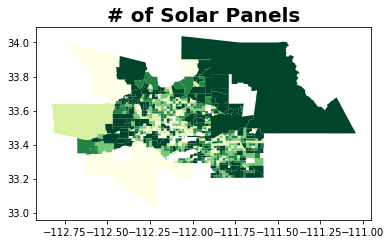

In [60]:
panelPlot = combined2.plot(column='number_of_panels_total', cmap='YlGn', scheme='quantiles');
panelPlot.set_title('# of Solar Panels', fontsize=20, fontweight='bold')\

Text(0.5, 1.0, 'White Population')

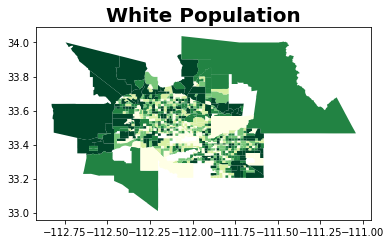

In [67]:
panelPlot = combined2.plot(column='White', cmap='YlGn', scheme='quantiles');
panelPlot.set_title('White Population', fontsize=20, fontweight='bold')

Text(0.5, 1.0, 'Black Population')

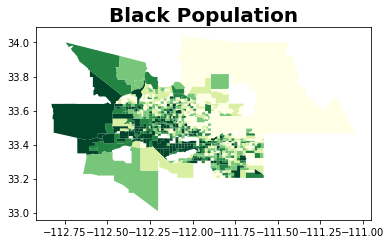

In [68]:
panelPlot = combined2.plot(column='Black', cmap='YlGn', scheme='quantiles');
panelPlot.set_title('Black Population', fontsize=20, fontweight='bold')\

Text(0.5, 1.0, 'Asian Population')

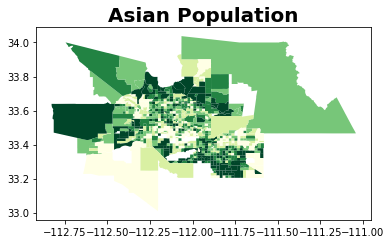

In [69]:
panelPlot = combined2.plot(column='Asian', cmap='YlGn', scheme='quantiles');
panelPlot.set_title('Asian Population', fontsize=20, fontweight='bold')\

Text(0.5, 1.0, 'Hispanic Population')

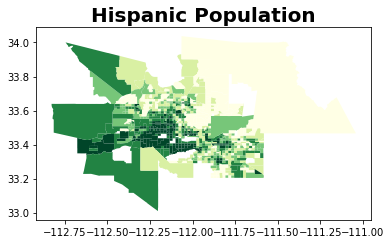

In [70]:
panelPlot = combined2.plot(column='Hispanic', cmap='YlGn', scheme='quantiles');
panelPlot.set_title('Hispanic Population', fontsize=20, fontweight='bold')\

Text(0.5, 1.0, 'Average Income')

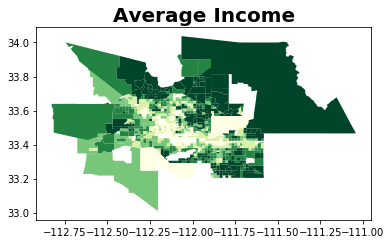

In [71]:
panelPlot = combined2.plot(column='Income', cmap='YlGn', scheme='quantiles');
panelPlot.set_title('Average Income', fontsize=20, fontweight='bold')\

In [16]:
combined2.fillna(0)
values = {'number_of_panels_total':0}
combined2.fillna(value=values)
combined2.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,geometry,state_name,number_of_panels_total,TotalPopulation,White,Black,Asian,Hispanic,Income,county
0,04,13.0,093104,4.013093e+09,931.04,Census Tract 931.04,G5020,S,3949828,4649,...,"POLYGON ((-112.18636 33.509569, -112.186353 33...",Arizona,234845.0,4808.0,3789.0,434.0,48.0,3106.0,24068.0,013
1,04,13.0,103205,4.013103e+09,1032.05,Census Tract 1032.05,G5020,S,2635515,0,...,"POLYGON ((-111.980315 33.598882, -111.979689 3...",Arizona,97097.0,2928.0,2801.0,37.0,12.0,124.0,98088.0,013
2,04,13.0,103206,4.013103e+09,1032.06,Census Tract 1032.06,G5020,S,2573798,0,...,"POLYGON ((-111.960605 33.597313, -111.960599 3...",Arizona,95602.0,2587.0,2276.0,44.0,99.0,202.0,113889.0,013
3,04,13.0,104501,4.013105e+09,1045.01,Census Tract 1045.01,G5020,S,1227304,23667,...,"POLYGON ((-112.097922 33.574878, -112.09704 33...",Arizona,52727.0,3872.0,2671.0,239.0,48.0,2199.0,25404.0,013
4,04,13.0,104502,4.013105e+09,1045.02,Census Tract 1045.02,G5020,S,1342092,0,...,"POLYGON ((-112.099614 33.57568699999999, -112....",Arizona,60429.0,5691.0,4893.0,400.0,0.0,3675.0,26986.0,013


In [36]:
combined2['logWhite'] = combined2['White']
combined2['logBlack'] = combined2['Black']
combined2['logAsian'] = combined2['Asian']
combined2['logHispanic'] = combined2['Hispanic']
combined2['logIncome'] = combined2['Income']
combined2.replace(np.nan,0,inplace=True)

In [37]:
train_vars = ['logWhite', 'logBlack', 'logAsian', 'logHispanic', 'logIncome']
trX, teX, trY, teY = train_test_split(combined2[train_vars], combined2['number_of_panels_total'], test_size =.25)

In [38]:
rf = RandomForestClassifier()
param_dist = {"n_estimators": stats.randint(2, 300), "max_features": ['sqrt',  'log2'], "min_samples_split": stats.randint(5, 50),"bootstrap": [True, False],"criterion": ["gini", "entropy"]}
random_rf = RandomizedSearchCV(rf, param_distributions=param_dist,n_iter=20, cv=5, verbose=1, n_jobs=-1)
random_rf.fit(trX, trY)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\Vincent\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.8min finished
C:\Users\Vincent\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000015495954978>, 'max_features': ['sqrt', 'log2'], 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000154959543C8>, 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None

In [39]:
random_rf.score(teX, teY)

0.043668122270742356

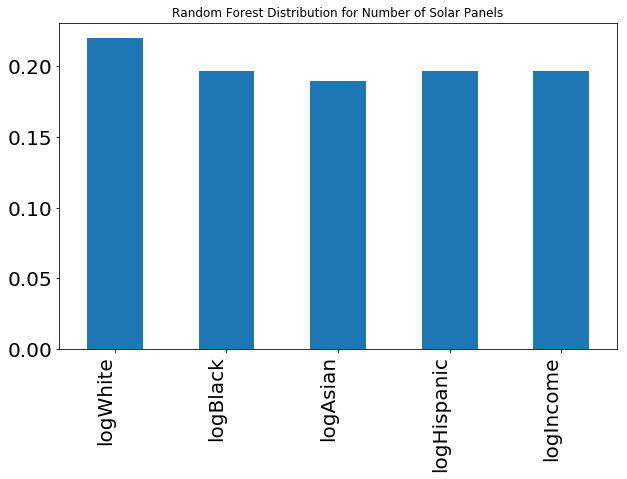

In [40]:
ax = pd.DataFrame(random_rf.best_estimator_.feature_importances_).plot(kind='bar',fontsize=20,figsize=(10,6))
ax.set_title('Random Forest Distribution for Number of Solar Panels')
ax.set_xticklabels(train_vars, rotation = 90, ha="right")
ax.get_legend().remove()